In [1]:
from __future__ import print_function

# Setup
import numpy as np
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread
import matplotlib.pyplot as plt
from time import time
import cv2
import matplotlib as mp

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [2]:
from panorama import harris_corners
rangex = 1000;
path = 'test8/'
img1 = imread(path + 'pic_0.tif')[0:rangex, 0:rangex]
img2 = imread(path + 'pic_1.tif')[0:rangex, 0:rangex]
img3 = imread(path + 'pic_0.tif')[0:rangex, 0:rangex]
img4 = imread(path + 'pic_1.tif')[0:rangex, 0:rangex] 

Keypoints 1 shape =  (384, 2)
Keypoints 2 shape =  (393, 2)


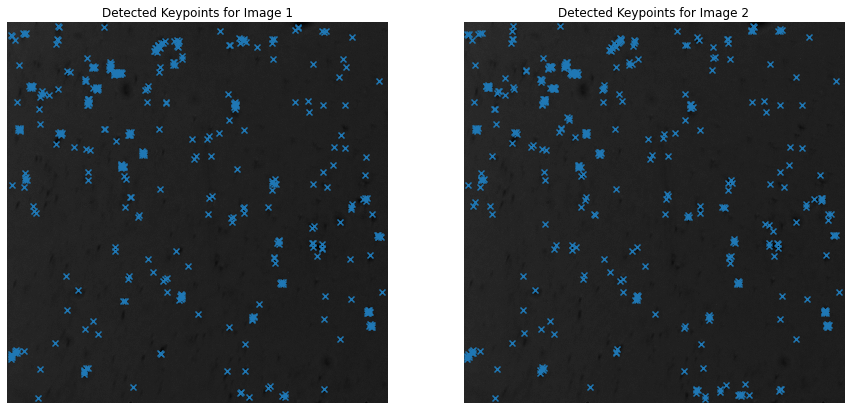

In [3]:
from panorama import harris_corners

# Detect keypoints in two images
hog_keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.000005,
                          exclude_border=8)
hog_keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.000005,
                          exclude_border=8)

print("Keypoints 1 shape = ", hog_keypoints1.shape)
print("Keypoints 2 shape = ", hog_keypoints2.shape)

# Display detected keypoints
plt.subplot(1,2,1)
plt.imshow(img1)
plt.scatter(hog_keypoints1[:,1], hog_keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(hog_keypoints2[:,1], hog_keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

HoG desc1 shape =  (384, 36)
HoG desc2 shape =  (393, 36)


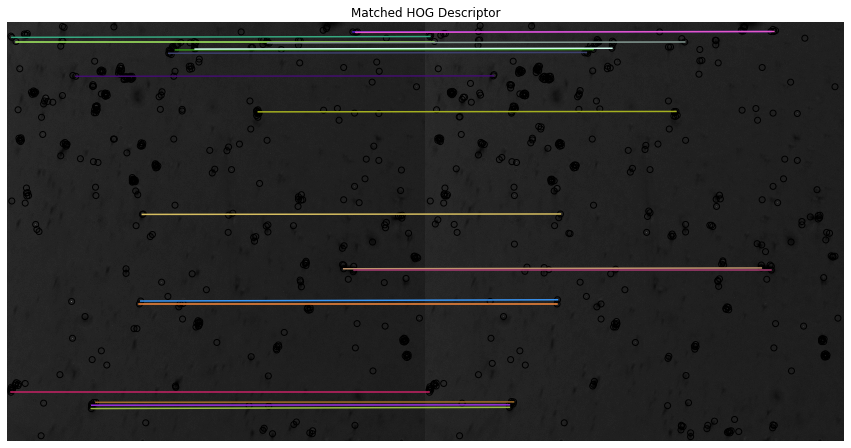

In [8]:
from panorama import simple_descriptor, match_descriptors, describe_keypoints
from panorama import hog_descriptor
from utils import plot_matches
# Set seed to compare output against solution
np.random.seed(131)

# Extract features from the corners
hog_desc1 = describe_keypoints(img1, hog_keypoints1,
                               desc_func=hog_descriptor,
                               patch_size=16)
hog_desc2 = describe_keypoints(img2, hog_keypoints2,
                               desc_func=hog_descriptor,
                               patch_size=16)

print("HoG desc1 shape = ", hog_desc1.shape)
print("HoG desc2 shape = ", hog_desc2.shape)

# Match descriptors in image1 to those in image2
hog_matches = match_descriptors(hog_desc1, hog_desc2, 0.6)
matches = []

for elem in hog_matches:
    i, j = elem
    dist = np.sqrt(np.sum((hog_keypoints1[i] - hog_keypoints2[j]) ** 2))
    if dist < 60:
        matches.append([i,j])
matches = np.array(matches).reshape(-1,2)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plt.title('Matched HOG Descriptor')
plot_matches(ax, img1, img2, hog_keypoints1, hog_keypoints2, matches)
plt.show()

In [9]:
from utils import get_output_space, warp_image
from panorama import fit_affine_matrix

# Extract matched keypoints
p1 = hog_keypoints1[matches[:,0]]
p2 = hog_keypoints2[matches[:,1]]

# Find affine transformation matrix H that maps p2 to p1
H = fit_affine_matrix(p1, p2)

output_shape, offset = get_output_space(img1, [img2], [H])
print(H.shape)
print(H)
print("Output shape:", output_shape)
print("Offset:", offset)


# Warp images into output sapce
img1_warped = warp_image(img1, np.eye(3), output_shape, offset)
# img1_mask = (img1_warped != -1) # Mask == 1 inside the image
# img1_warped[~img1_mask] = 0     # Return background values to 0

img2_warped = warp_image(img2, H, output_shape, offset)
# img2_mask = (img2_warped != -1) # Mask == 1 inside the image
# img2_warped[~img2_mask] = 0     # Return background values to 0

# # Plot warped images
# plt.subplot(1,2,1)
# plt.imshow(img1_warped)
# plt.title('Image 1 Warped')
# plt.axis('off')

# plt.subplot(1,2,2)
# plt.imshow(img2_warped)
# plt.title('Image 2 Warped')
# plt.axis('off')

# plt.show()

(3, 3)
[[9.99856923e-01 1.02021784e-04 0.00000000e+00]
 [3.57185517e-04 1.00105331e+00 0.00000000e+00]
 [1.22994757e+00 1.33478158e+00 1.00000000e+00]]
Output shape: [1002 1003]
Offset: [0. 0.]


Text(0.5, 1.0, 'img2_warped')

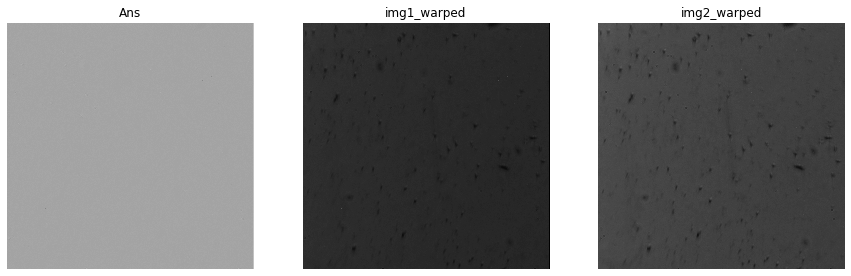

In [10]:
ans = img2_warped - img1_warped

plt.subplot(1,3,1)
plt.imshow(ans)
plt.axis('off')
plt.title('Ans')

plt.subplot(1,3,2)
plt.imshow(img1_warped)
plt.axis('off')
plt.title('img1_warped')

plt.subplot(1,3,3)
plt.imshow(img2_warped)
plt.axis('off')
plt.title('img2_warped')

In [11]:
cv2.imwrite(path + 'compare1.tif',ans)
res = img4 - img3
cv2.imwrite(path + 'compare2.tif',res)
# plt.imshow(res)
# plt.axis('off')
# plt.title('Harris Corner Response')

True